
## Exercise instruction

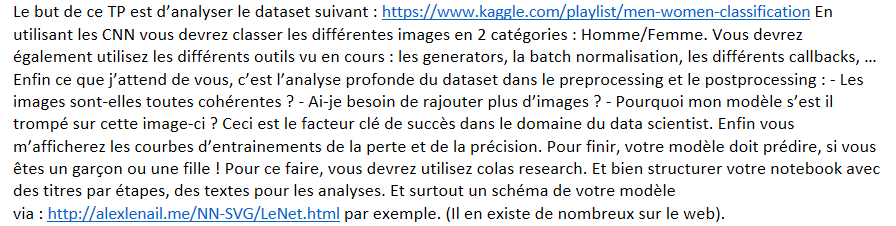

## Import Library

In [0]:
from contextlib import contextmanager
import os
import sys

In [0]:
import tensorflow as tf
import numpy as np
import cv2
import math
import pathlib
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from matplotlib import pyplot as plt

Dataset : https://www.kaggle.com/playlist/men-women-classification

In [0]:
@contextmanager
def suppress_stdout():
  with open(os.devnull, "w") as devnull:
    old_stdout = sys.stdout
    sys.stdout = devnull
    try:  
        yield
    finally:
      sys.stdout = old_stdout

In [0]:
file = open('/content/kaggle.json', 'w')
file.write('{"username":"pietrinicolas","key":"dd6c8cd0e5a0036dea1dabaaf8f1daee"}')
file.close()

In [57]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d playlist/men-women-classification

kaggle.json
men-women-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [58]:
print("Unzipping files...")
with suppress_stdout():
  !unzip men-women-classification.zip
print("Files unzipped")

Unzipping files...
Files unzipped


In [0]:
! mkdir prediction
! mkdir prediction/men
! mkdir prediction/women
!ls -Q /content/men | head -6 | xargs -i mv /content/men/{} /content/prediction/men
!ls -Q /content/women | head -6 | xargs -i mv /content/women/{} /content/prediction/women

In [0]:
! mkdir people
! mv /content/men /content/people/
! mv /content/women /content/people/

In [61]:
filenames = os.listdir("/content/people/")
print(filenames)

['women', 'men']


## Prepare Traning Data

In [0]:
img_size = 150

#===# creating dataset
def load_imgs_and_labels(filepaths, flip=False):

  dataset = []
  labels = []

  for path in filepaths:
    dataset.append(process_image( './' + str(path), flip))
    labels.append(translate_label_from_str_to_int(str(path).split('/')[-2]))

    if len(labels)%500 == 0:
      print(str(len(labels)) + '/' + str(len(filepaths)))

  return [ dataset, labels ]

#===# processing one image
# loading the file
# optionally: flipping horizontally
# resizing
# rescaling

def process_image(filepath, flip):
  img = 0
  try:
    img = cv2.imread( filepath, cv2.IMREAD_UNCHANGED)
    if flip:
      img = cv2.flip(img, 1)
    img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
    img = img/255
    
  except Exception as e:
    pass

  return img

#===# working around labels
def translate_label_from_str_to_int(str_label):
  labels = {
      "men": 0,
      "women": 1
  }
  return labels.get(str_label)

def translate_label_from_int_to_str(int_label):
  labels = {
      0: "man",
      1: "woman"
  }
  return labels.get(int_label)

In [0]:
data_dir = pathlib.Path('people')
file_paths = np.array(list(data_dir.glob('*/*.jpg')))

In [64]:
np.random.shuffle(file_paths)
datas = load_imgs_and_labels(file_paths)

500/2985
1000/2985
1500/2985
2000/2985
2500/2985


In [0]:
dataset = datas[0]
labels = datas[1]

In [66]:
import pandas as pd 
df = pd.DataFrame({
    'filename': dataset,
    'category': labels
})

df.head()
df.tail()

,filename,category
2980,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",1
2981,"[[[0.1843137254901961, 0.0, 0.2980392156862745...",1
2982,"[[[0.3843137254901961, 0.615686274509804, 0.79...",0
2983,"[[[0.3137254901960784, 0.34901960784313724, 0....",1
2984,"[[[0.43137254901960786, 0.4235294117647059, 0....",0


In [67]:
df.head()

,filename,category
0,"[[[0.4196078431372549, 0.5098039215686274, 0.5...",0
1,"[[[1.0, 1.0, 1.0], [1.0, 0.996078431372549, 1....",0
2,"[[[0.5098039215686274, 0.5882352941176471, 0.6...",1
3,"[[[0.8705882352941177, 0.8745098039215686, 0.8...",1
4,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0


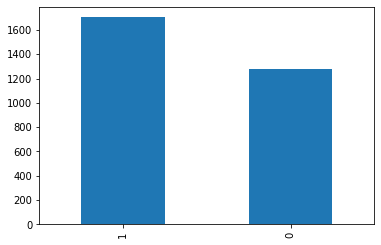

In [68]:
df['category'].value_counts().plot.bar()

From our data we have about 1600 men and 1200 women

In [0]:
DS_SIZE = len(datas[0])
TEST_SIZE = math.ceil(DS_SIZE *0.2)

train_data = dataset[0:-TEST_SIZE]
train_labels = labels[0:-TEST_SIZE]

test_data = dataset[-TEST_SIZE:]
test_labels = labels[-TEST_SIZE:]

In [0]:
# save data after first run
# np.save('test_data', test_data)
# np.save('train_data', train_data)
# np.save('test_labels', test_labels)
# np.save('train_labels', train_labels)

In [0]:
# restore data after crash
# test_data = np.load('test_data.npy')
# train_data = np.load('train_data.npy')

# test_labels = np.load('test_labels.npy')
# train_labels = np.load('train_labels.npy')

## See sample image

man


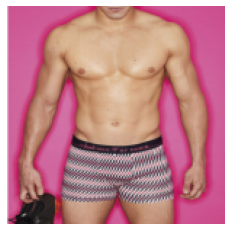

In [72]:
print(translate_label_from_int_to_str(train_labels[150]))
plt.imshow(cv2.cvtColor(train_data[150].astype('float32'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [73]:
class training_ceiling(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = training_ceiling()

epochs=3
batch_size=128

model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Convolution2D(32, (3,3), activation="relu", input_shape=(img_size,img_size,3)),                       
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation= tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(128, activation= tf.nn.relu),
    # tf.keras.layers.Dense(64, activation= tf.nn.relu),

    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.summary()

from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.2, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        shear_range=0.1,
        )
data_generator.fit(np.asarray(train_data))

model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    data_generator.flow(
        np.asarray(train_data),
        np.asarray(train_labels), 
        batch_size=batch_size),
    epochs = epochs, 
    validation_data=(np.asarray(test_data),
                     np.asarray(test_labels)),
    verbose = 1, 
    steps_per_epoch=np.asarray(train_data).shape[0] // batch_size,
    callbacks=[callbacks])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)      

## Fit Model

In [0]:
# history = model.fit(
#     np.asarray(train_data), 
#     np.asarray(train_labels), 
#     validation_data=(np.asarray(test_data),np.asarray(test_labels)), 
#     epochs=epochs, 
#     batch_size=batch_size, 
#     callbacks=[callbacks])

In [75]:
model.evaluate(np.asarray(test_data), np.asarray(test_labels))

19/19 [==============================] - 0s 9ms/step - loss: 0.6450 - accuracy: 0.6365


[0.6449662446975708, 0.6365159153938293]

## Save Model

In [0]:
# don't think we need it
model.save_weights("model.h5")

## Virtualize Training

In [0]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
# ax1.plot(history.history['loss'], color='b', label="Training loss")
# ax1.plot(history.history['val_loss'], color='r', label="validation loss")


# ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
# ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")


# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# legend = plt.legend(loc='best', shadow=True)
# plt.tight_layout()
# plt.show()

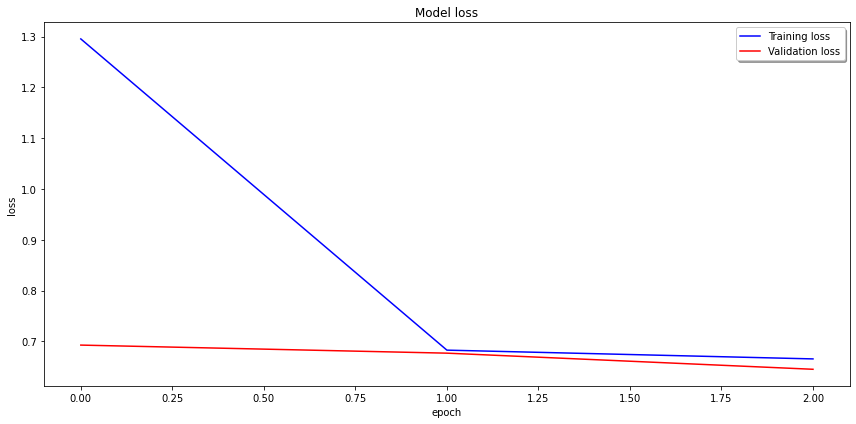

In [78]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

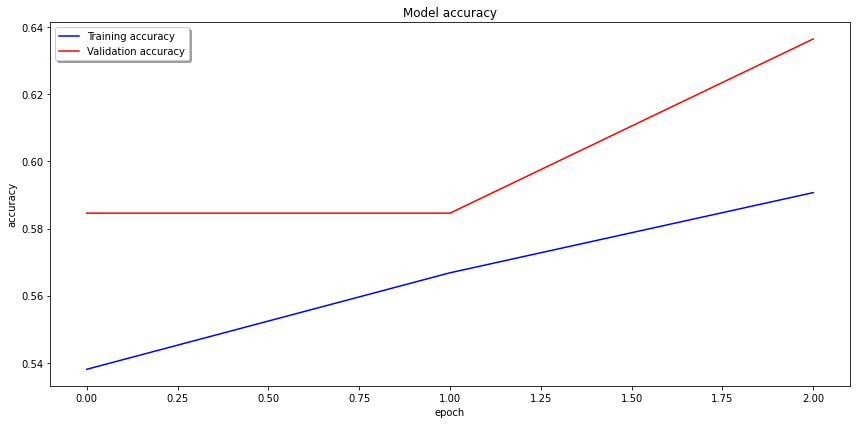

In [79]:
fig, ax2 = plt.subplots(figsize=(12, 6))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## See predicted result with images

In [0]:
# predictions = model.predict_classes(test_data)
predictions = model.predict(np.asarray(test_data))

In [0]:

import random


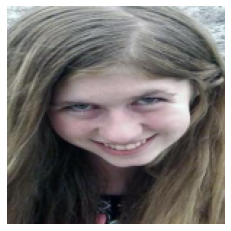

Prediction: [0.51090664 0.48909333]
So it is: woman


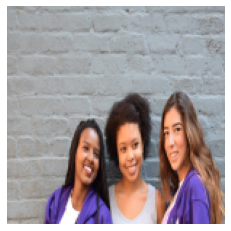

Prediction: [0.51204944 0.4879506 ]
So it is: woman


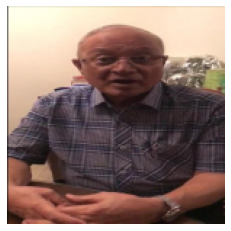

Prediction: [0.36136928 0.63863075]
So it is: man


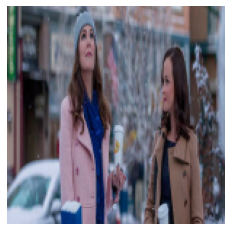

Prediction: [0.4908255  0.50917447]
So it is: woman


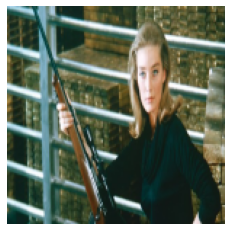

Prediction: [0.4396834  0.56031656]
So it is: woman


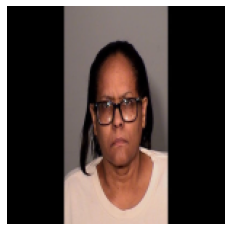

Prediction: [0.37486717 0.62513286]
So it is: woman


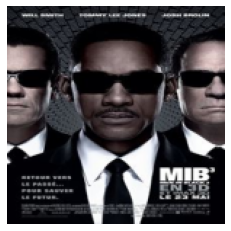

Prediction: [0.42922604 0.57077396]
So it is: man


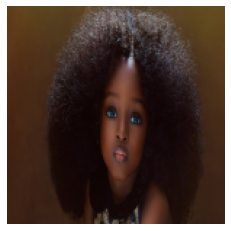

Prediction: [0.2902652 0.7097348]
So it is: woman


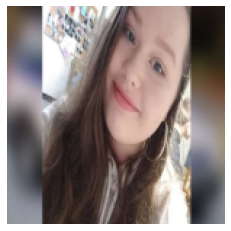

Prediction: [0.50414157 0.49585846]
So it is: woman


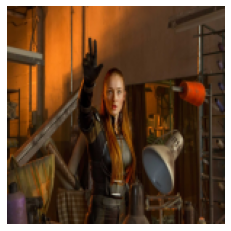

Prediction: [0.5079726 0.4920274]
So it is: woman


In [89]:
# random_indices = [random.randint(1, 599) for i in range(9)]

# plt.figure(figsize=(12,12))
# for i, index in enumerate(random_indices):
#     pred = predictions[index]
#     pred = 'man' if pred==0 else 'woman'
#     actual = 'man' if test_labels[index]==0 else 'woman'
#     plt.subplot(3,3,i+1)
#     plt.imshow(test_data[index], cmap='gray', interpolation='none')
#     plt.title(f"Predicted: {pred}, \n Class: {actual}")
#     plt.tight_layout()

filenames = os.listdir("/content/prediction/")
data_dir = pathlib.Path('prediction')
file_paths = np.array(list(data_dir.glob('*/*.*')))
np.random.shuffle(file_paths)
prediction_data = load_imgs_and_labels(file_paths)
# predictions = model.predict_classes(prediction_data)

prediction_dataset = prediction_data[0]
prediction_labels = prediction_data[1]

# classifications = model.predict_classes(prediction_dataset)

classifications = model.predict(np.asarray(prediction_dataset))

def display_predictions(test_case):
  plt.imshow(cv2.cvtColor(test_data[test_case].astype('float32'), cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

  print(f"Prediction: {classifications[test_case]}")
  print(f"So it is: {translate_label_from_int_to_str(test_labels[test_case])}")

#test_cases = [10, 50, 100, 150, 200]
for case in range(10):
  display_predictions(case)

In [0]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()